#Denoising Diffusion Probabilistic Model from scratch

### Reference

https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing

## Dataset

Using CIFAR10 Dataset, we will implement DDPM from scracth and train it.

100%|██████████| 170498071/170498071 [00:10<00:00, 15871655.92it/s]


Extracting ./cifar-10-python.tar.gz to .
device: cuda:0


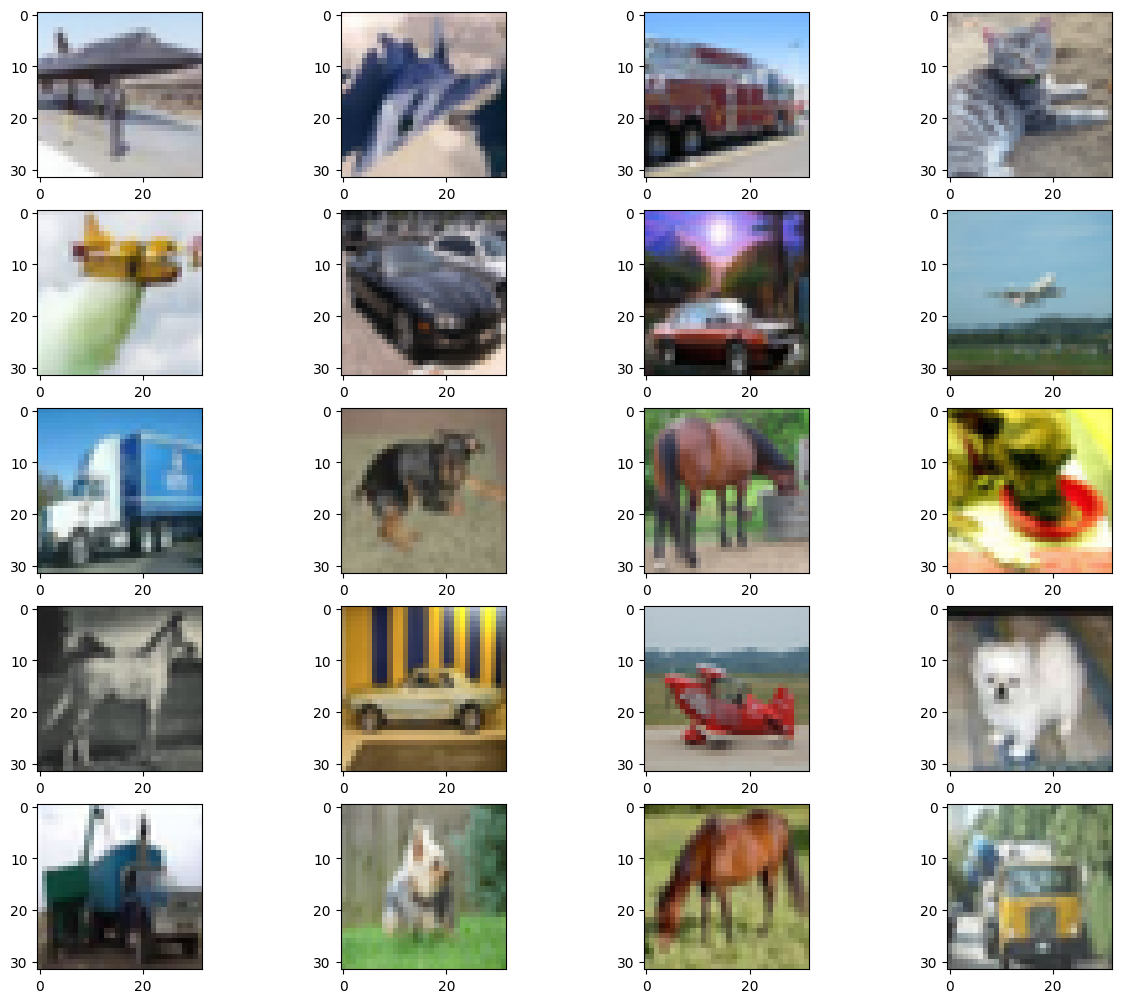

In [ ]:
import torch
import random
import torchvision
import matplotlib.pyplot as plt

def show_images(dataset, num_samples=20, cols=4):
  plt.figure(figsize=(15,15))

  samples = random.choices(range(0, len(dataset)), k=num_samples)

  for index, sample in enumerate(samples):
    image, label = dataset[sample]
    plt.subplot(int(num_samples / cols) + 1, cols, index + 1)
    plt.imshow(image)
    # print(dataset[sample])


data = torchvision.datasets.CIFAR10(root='.', download=True)
show_images(data)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: %s"%(device))

torch.cuda.empty_cache()

## Preliminary
### `gather` method
<br/>

#### Description

ex. ``torch.gather(value, 1, indices)``

``gathered[i][j][k] = value[i][indices[i][0][k]][k]``

<br/>

#### Reference
https://data-newbie.tistory.com/709

#### In 2D

In [ ]:
import torch

matrix = torch.range(0,99)
print(matrix)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97.,
        98., 99.])


<ipython-input-2-26a09d2f238e>:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  matrix = torch.range(0,99)


In [ ]:
matrix = matrix.reshape(10, 10)
print(matrix)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
        [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
        [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.],
        [40., 41., 42., 43., 44., 45., 46., 47., 48., 49.],
        [50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
        [60., 61., 62., 63., 64., 65., 66., 67., 68., 69.],
        [70., 71., 72., 73., 74., 75., 76., 77., 78., 79.],
        [80., 81., 82., 83., 84., 85., 86., 87., 88., 89.],
        [90., 91., 92., 93., 94., 95., 96., 97., 98., 99.]])


In [ ]:
indices = [i for i in range(0, 10)]
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
indices = torch.tensor(indices).unsqueeze(-1)
print(indices)

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])


`matrix` and `indices` should have same dimensions except for the dimension 
indicated by `dim`.

In [ ]:
print(torch.gather(matrix, 1, indices))

tensor([[ 0.],
        [11.],
        [22.],
        [33.],
        [44.],
        [55.],
        [66.],
        [77.],
        [88.],
        [99.]])


#### In 3D

In [ ]:
batch_size = 8
max_seq_len = 9
hidden_size = 6

temp = torch.empty(batch_size, max_seq_len, hidden_size)

for i in range(batch_size):
  for j in range(max_seq_len):
    for k in range(hidden_size):
      temp[i, j, k] = i + j * 10 + k * 100

In [ ]:
print(temp[:,6,:])

tensor([[ 60., 160., 260., 360., 460., 560.],
        [ 61., 161., 261., 361., 461., 561.],
        [ 62., 162., 262., 362., 462., 562.],
        [ 63., 163., 263., 363., 463., 563.],
        [ 64., 164., 264., 364., 464., 564.],
        [ 65., 165., 265., 365., 465., 565.],
        [ 66., 166., 266., 366., 466., 566.],
        [ 67., 167., 267., 367., 467., 567.]])


In [ ]:
len = torch.LongTensor([5, 6, 1, 8, 3, 7, 3, 4])
len = len.unsqueeze(-1)
print(len)
print(len.shape)

tensor([[5],
        [6],
        [1],
        [8],
        [3],
        [7],
        [3],
        [4]])
torch.Size([8, 1])


In [ ]:
len = len.repeat(1, 6)
print(len)
print(len.shape)

tensor([[5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6],
        [1, 1, 1, 1, 1, 1],
        [8, 8, 8, 8, 8, 8],
        [3, 3, 3, 3, 3, 3],
        [7, 7, 7, 7, 7, 7],
        [3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4]])
torch.Size([8, 6])


In [ ]:
len = len.unsqueeze(1)
print(len)
print(len.shape)

tensor([[[5, 5, 5, 5, 5, 5]],

        [[6, 6, 6, 6, 6, 6]],

        [[1, 1, 1, 1, 1, 1]],

        [[8, 8, 8, 8, 8, 8]],

        [[3, 3, 3, 3, 3, 3]],

        [[7, 7, 7, 7, 7, 7]],

        [[3, 3, 3, 3, 3, 3]],

        [[4, 4, 4, 4, 4, 4]]])
torch.Size([8, 1, 6])


In [ ]:
torch.gather(temp, 1, len)

tensor([[[ 50., 150., 250., 350., 450., 550.]],

        [[ 61., 161., 261., 361., 461., 561.]],

        [[ 12., 112., 212., 312., 412., 512.]],

        [[ 83., 183., 283., 383., 483., 583.]],

        [[ 34., 134., 234., 334., 434., 534.]],

        [[ 75., 175., 275., 375., 475., 575.]],

        [[ 36., 136., 236., 336., 436., 536.]],

        [[ 47., 147., 247., 347., 447., 547.]]])

#### Reference

https://woongjun-warehouse.tistory.com/48

In [ ]:
val = torch.arange(1, 9).reshape(2, -1, 2)
print(val)
print(val.shape)

indices = torch.arange(2).expand(2, 2).reshape(2, 1, 2)
print(indices)
print(indices.shape)

tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])
torch.Size([2, 2, 2])
tensor([[[0, 1]],

        [[0, 1]]])
torch.Size([2, 1, 2])


In [ ]:
result = torch.gather(val, 1, indices)
print(result)
print(result.shape)

tensor([[[1, 4]],

        [[5, 8]]])
torch.Size([2, 1, 2])


In [ ]:
shapes = [10, 20, 30]
shapes = torch.Tensor(shapes)
print(shapes)
print(shapes.size())

tensor([10., 20., 30.])
torch.Size([3])


## Forward Process

### Noise Scheduler

In [ ]:
import torch
import torch.nn.functional as F

# Values of beta are one of the hyperparameters.
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
  return torch.linspace(start, end, timesteps)


def get_index_from_list(vals, t, x_shape):
  # shape of x_shape: (batch_size, 3, img_size, img_size)
  batch_size = t.shape[0]
  # shape of out: (batch_size, 1)
  out = torch.gather(vals, -1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

We don't need to get a sampling result at time step $t$ by going through all steps.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FtkeHb%2Fbtr8KILpWxP%2FSsnxKMbxHychErW6G41FG0%2Fimg.jpg"></img>

In [ ]:
T = 10
betas = linear_beta_schedule(timesteps=T)
print(betas)

tensor([1.0000e-04, 2.3111e-03, 4.5222e-03, 6.7333e-03, 8.9444e-03, 1.1156e-02,
        1.3367e-02, 1.5578e-02, 1.7789e-02, 2.0000e-02])


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FMlyih%2Fbtr8KKbs6w7%2FInhOy3NvD6Vf1o5lvIntg0%2Fimg.jpg"></img>

In [ ]:
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
print(alphas_cumprod)

tensor([0.9999, 0.9976, 0.9931, 0.9864, 0.9776, 0.9667, 0.9537, 0.9389, 0.9222,
        0.9037])


Shift `alphas_cumprod` to the right by one step.

In [ ]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
print(alphas_cumprod_prev)

tensor([1.0000, 0.9999, 0.9976, 0.9931, 0.9864, 0.9776, 0.9667, 0.9537, 0.9389,
        0.9222])


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlhuOe%2Fbtr8XyUx4Si%2FpdIoZV7bvyJCZM4X07tkhK%2Fimg.jpg"></img>

In [ ]:
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
print(sqrt_recip_alphas)

tensor([1.0000, 1.0012, 1.0023, 1.0034, 1.0045, 1.0056, 1.0068, 1.0079, 1.0090,
        1.0102])


In [ ]:
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
print(sqrt_alphas_cumprod)

tensor([0.9999, 0.9988, 0.9965, 0.9932, 0.9887, 0.9832, 0.9766, 0.9690, 0.9603,
        0.9507])


In [ ]:
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
print(sqrt_one_minus_alphas_cumprod)

tensor([0.0100, 0.0491, 0.0832, 0.1167, 0.1498, 0.1826, 0.2151, 0.2472, 0.2790,
        0.3103])


In [ ]:
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
print(posterior_variance)

tensor([0.0000e+00, 9.5877e-05, 1.5750e-03, 3.4249e-03, 5.4264e-03, 7.5063e-03,
        9.6330e-03, 1.1791e-02, 1.3971e-02, 1.6168e-02])


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbxHn8P%2Fbtr8OVixcof%2FsPtdd71y6XeyaewaBeg0s0%2Fimg.jpg"></img>

In [ ]:
def forward_diffusion_sample(x_0, t, device="cpu"):
  noise = torch.randn_like(x_0)
  sqrt_alphas_cumprod_t = get_index_from_list(
      sqrt_alphas_cumprod, t, x_0.shape
  )
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x_0.shape
  )

  # Please refer to the optimization.
  return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
  + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

## DataLoader

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 2

In [ ]:
def load_transformed_dataset():
  data_transforms = [
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(), # Scaling to [0, 1]
      transforms.Lambda(lambda t: (t * 2) - 1) # Scaling to [-1, 1]
  ]

  data_transform = transforms.Compose(data_transforms)

  # Prepare train and test dataset.
  train = torchvision.datasets.CIFAR100(root='.', download=True, transform=data_transform, train=True)
  test = torchvision.datasets.CIFAR100(root='.', download=True, transform=data_transform, train=False)

  return torch.utils.data.ConcatDataset([train, test])

In [ ]:
def show_tensor_image(image):
  reverse_transforms = transforms.Compose([
      transforms.Lambda(lambda t: (t + 1) / 2),
      transforms.Lambda(lambda t: t.permute(1, 2, 0)), # shape change: (channel, width, height) -> (width, height, channel)
      transforms.Lambda(lambda t: t * 255.),
      transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
      transforms.ToPILImage()
  ])

  if len(image.shape) == 4:
    image = image[0, :, :, :]

  plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 169001437/169001437 [00:10<00:00, 15576942.33it/s]


Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


<ipython-input-14-13441d16b38f>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, int(index / step_size) + 1)


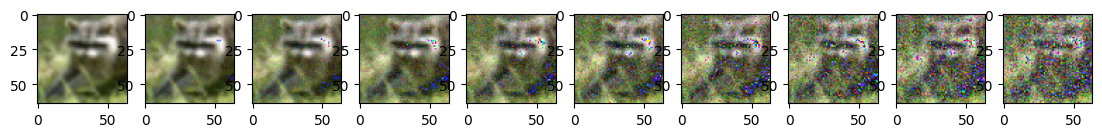

In [ ]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
step_size = int(T/num_images)

for index in range(0, T, step_size):
  t = torch.Tensor([index]).type(torch.int64)
  plt.subplot(1, num_images + 1, int(index / step_size) + 1)
  img, noise = forward_diffusion_sample(image, t)
  show_tensor_image(img)

## Backward Process (Denoising Process)

### U-net Architecture

In [ ]:
from torch import nn
import math

In [ ]:
class Block(nn.Module):
  def __init__(self, in_channel, out_channel, time_emb, up=False):
    super().__init__()
    self.time_mlp = nn.Linear(time_emb, out_channel)
    if up:
      self.conv1 = nn.Conv2d(2 * in_channel, out_channel, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_channel, out_channel, kernel_size=4, stride=2, padding=1)
    else:
      self.conv1 = nn.Conv2d(in_channel, out_channel, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_channel, out_channel, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
    self.bnorm1 = nn.BatchNorm2d(out_channel)
    self.bnorm2 = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU()

  def forward(self, x, t):
    h = self.bnorm1(self.relu(self.conv1(x)))
    time_emb = self.relu(self.time_mlp(t))
    time_emb = time_emb[(...,) + (None,) * 2]

    h = h + time_emb
    h = self.bnorm2(self.relu(self.conv2(h)))

    return self.transform(h)

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

    return embeddings

In [ ]:
class SimpleUnet(nn.Module):
  def __init__(self):
    super().__init__()
    image_channels = 3
    down_channels = (64, 128, 256, 512, 1024)
    up_channels = (1024, 512, 256, 128, 64)
    out_dim = 3
    time_emb_dim = 32

    # Time Embedding
    self.time_mlp = nn.Sequential(
        PositionalEncoding(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )

    # CNNs don't care about sizes of the inputs.
    # The number of channels should increase when we go through encoder of Unet.
    self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

    self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) \
                                for i in range(len(down_channels) - 1)])
    
    # The number of channels should decrease when we go through encoder of Unet.
    self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) \
                              for i in range(len(up_channels) - 1)])
    
    # Convolution with 1 x 1 sized kernel
    self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

  def forward(self, x, timestep):
    t = self.time_mlp(timestep)
    x = self.conv0(x)

    # Skip connection
    residual_inputs = []

    for down in self.downs:
      x = down(x, t)
      residual_inputs.append(x)

    for up in self.ups:
      residual_x = residual_inputs.pop()
      x = torch.cat((x, residual_x), dim=-1)
      x = up(x, t)

    return self.output(x)

In [ ]:
model = SimpleUnet()
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
model

Number of parameters:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): PositionalEncoding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform

## Loss

In [ ]:
def get_loss(model, x_0, t):
  x_noisy, noise = forward_diffusion_sample(x_0, t, device)
  noise_pred = model(x_noisy, t)
  return F.l1_loss(noise, noise_pred)

## Sampling

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbxHn8P%2Fbtr8OVixcof%2FsPtdd71y6XeyaewaBeg0s0%2Fimg.jpg"></img>

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
  betas_t = get_index_from_list(betas, t, x.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x.shape
  )
  sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

  # Current image can be produced by removing predicted noise from previous image.
  model_mean = sqrt_recip_alphas_t * (
      x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
  )

  posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

  if t == 0:
    return model_mean
  else:
    noise = torch.randn_like(x)

  return model_mean + torch.sqrt(posterior_variance_t) * noise

In [ ]:
@torch.no_grad()
def sample_plot_image():
  img_size = IMG_SIZE
  img = torch.randn((1, 3, img_size, img_size), device=device)
  plt.figure(figsize=(15,15))
  plt.axis('off')
  num_images = 10

  step_size = int(T / num_images)

  for i in range(0, T, step_size):
    t = torch.full((1,), i, device=device, dtype=torch.long)
    img = sample_timestep(img, t)
    
    if i % step_size == 0:
      plt.subplot(1, num_images, int(i / step_size) + 1)
      show_tensor_image(img.detach().cpu())

  plt.show()

## Training

In [ ]:
from torch.optim import Adam

model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

In [ ]:
for epoch in range(epochs):
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()

    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, batch[0], t)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()}")
      sample_plot_image()